# Rapid Adiabatic Passage Simulations for $\text{CO}$

In [1]:
# importing some paraphernelia 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('text', usetex=True)
mpl.rc('font', family='sans-serif', serif='computer modern')
mpl.rc('font', size=15)

Also, the lifetime of an excited state $\tau$ and the corresponding einstein coefficient of the transition $A_{1\rightarrow 0}$ are related as,
$$
A_{1\rightarrow 0} = \frac{1}{\tau}.
$$
where $\tau$ is an experimentally, measurably quantity.

We can transition dipole moment from $A_{1\rightarrow 0}$ as,

$$
A_{1\rightarrow 0} = \frac{16\pi^3\bar{\nu}^3}{3\varepsilon_{0}h}\mu_{10}^{2}
$$

(For reference see, the textbook by Peter Bernath.)


In [2]:
from scipy.constants import epsilon_0, mu_0, h

def calc_dipole(A, nu_bar):
    """Calculates transition dipole matrix element mu_10 (C-m) for a transition with einstein coefficient A (s^{-1}) and, correspdoning wavenumber nu_bar (cm^-1)
    """
    const = 16*np.pi**3/(3*epsilon_0*h)    
    nu_bar = 100*nu_bar
    mu_10 = np.sqrt(A/(const*nu_bar**3))
    return mu_10

```sh
Isotope	  ν         	S	      A	     γair	γself	E"	        nair	 δair	J'	J"
12C16O	2142.4729	2.627e-23	32.56	0.0618	0.068	2223.2714	0.75	-0.002	7	6
12C16O	2142.7199	6.172e-28	50.61	0.0545	0.059	4656.1724	0.71	-0.002	15	14
12C16O	2145.9173	5.01e-28	50.95	0.0538	0.058	4712.7156	0.7     -0.002	16	15
12C16O	2145.9988	2.643e-23	33.01	0.0606	0.066	2249.9334	0.75	-0.002	8	7
12C16O	2147.0811	9.29e-20	11.71	0.0803	0.087	0.0	        0.76	-0.002	1	0
12C16O	2149.0774	3.978e-28	51.28	0.0531	0.057	4773.0161	0.69	-0.002	17	16
12C16O	2149.4885	2.569e-23	33.39	0.0595	0.065	2280.4012	0.75	-0.002	9	8
12C16O	2150.8560	1.828e-19	14.13	0.0757	0.081	3.845       0.75	-0.002	2	1
12C16O	2152.1999	3.09e-28	51.61	0.0524	0.056	4837.0717	0.68	-0.002	18	17
12C16O	2152.9419	2.421e-23	33.74	0.0586	0.064	2314.6739	0.75	-0.002	10	9
12C16O	2154.5956	2.646e-19	15.23	0.0712	0.077	11.535	    0.74	-0.003	3	2
```

In [3]:
def clebsch_gordon_coefficient(branch, J, M):
    if branch=="R":
        coeff = np.sqrt(((J-M+1)*(J+M+1))/((2*J+1)*(J+1)))
    if branch=="Q":
        coeff = np.sqrt((M**2)/(J*(J+1)))
    if branch=="P":
        coeff = np.sqrt(((J-M)*(J+M))/(J*(2*J+1)))
    return coeff

In [4]:
J=0
A10 = 11.71	 # 2147.0811 cm^-1 1<-0 transition
nubar = 2147.0811 # cm^{-1}
#Final dipole calculation
dipole = calc_dipole(A10, nubar)
CG_coeff = clebsch_gordon_coefficient("R", J, 0)
dipole = dipole*CG_coeff
print("Clebsch-Gordon coefficient for R branch transition J'={Jpp:d}->J''={Jp:1d}, M=0 : {CG:6.4f}".format(Jp=J+1,Jpp=J,CG=CG_coeff))
print("Dipole moment of the CO molecule : %8.6E C-m"%dipole)
print('(OR) %6.2f D'%(dipole/(3.33564*1E-30)))

Clebsch-Gordon coefficient for R branch transition J'=0->J''=1, M=0 : 1.0000
Dipole moment of the CO molecule : 2.048726E-31 C-m
(OR)   0.06 D


In [5]:
import os 
os.environ['OMP_NUM_THREADS'] = '4'
from rap_mb.cpp import *
from rap_mb.helpers import *


In [6]:
wl_nm = 1/(nubar*1e2)*1e9 # nm
r = 0.2 # cm   
z = np.linspace(-20, 20, 5000) # cm
focal_lengths = [10, 18.0, 25.4, 40.0, 65.0] #cm
colors = {10.0:'red', 18.0:'black', 25.40:'green', 40.0:'mediumblue', 65.0:'purple'}

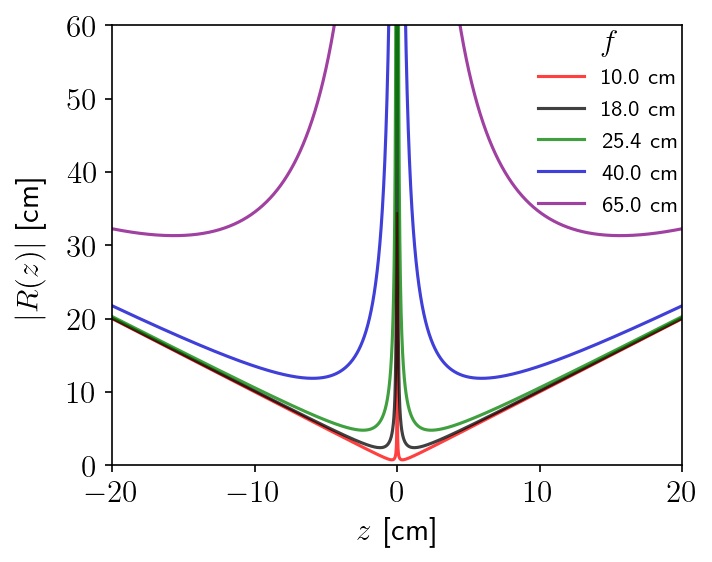

In [7]:
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = f, wl_nm, r
    label = '{f:2.1f} cm'.format(f=f)
    w0 = wl_nm*1e-7*f/(np.pi*r)
    ax.plot(z, abs(R(z, w0, wl_nm)), label=label, color=colors[f], alpha=0.75)
ax.set_ylim(0, 60)
ax.set_xlim(-20,20)
ax.set_xlabel('$z$ [cm]')
ax.legend(loc='center', bbox_to_anchor=[.87,0.78], frameon=False, title=r'$f$', fontsize=11)
ax.set_ylabel(r'$|R(z)|$ [cm]',labelpad=10)
fig.tight_layout()
fig.savefig('images/beam_radius.pdf', dpi=300)
fig.savefig('images/beam_radius.png', dpi=300)

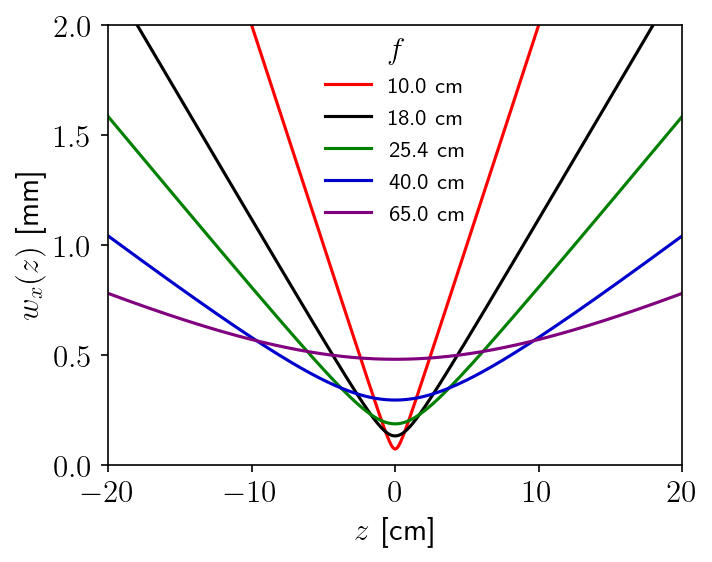

In [8]:
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = f, wl_nm, r
    label = '{f:2.1f} cm'.format(f=f)
    ax.plot(z, w(z, wl_nm, r, f, focused=True)*10, label=label, color=colors[f])
ax.set_ylim(0, 2.0)
ax.set_xlim(-20,20)
ax.set_xlabel(r'$z$ [cm]')
ax.legend(bbox_to_anchor=[.5,0.5], frameon=False, title=r'$f$', fontsize=11)
ax.set_ylabel(r'$w_{x}(z)$ [mm]')
fig.tight_layout()
fig.savefig('images/beam_width.pdf', dpi=300)
fig.savefig('images/beam_width.png', dpi=300)

/home/vijay/Desktop/rap-mb/rap_mb/helpers.py:34: RuntimeWarning: divide by zero encountered in divide
  R =  z + zr(w0, wl_nm)**2/z


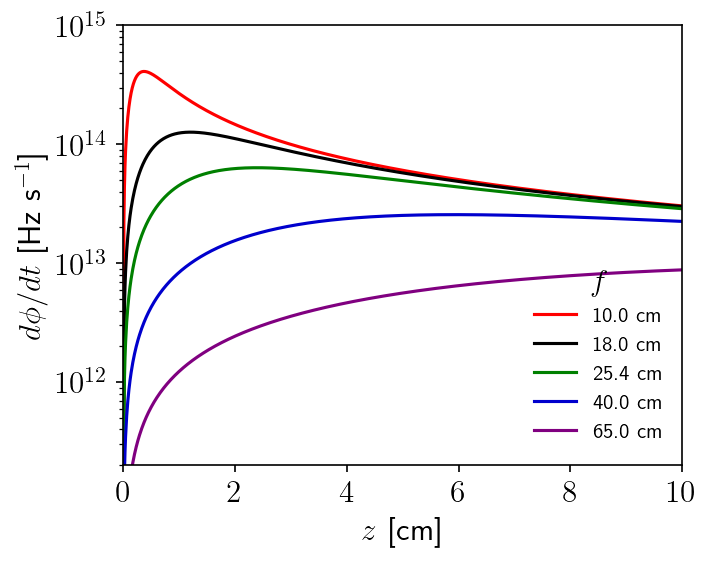

In [9]:
vx = 1500 # m/s
z = np.linspace(0,20, 2000)
focal_lengths = [10, 18.0, 25.4, 40.0, 65.0] #cm
colors = {10.0:'red', 18.0:'black', 25.40:'green', 40.0:'mediumblue', 65.0:'purple'}
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = wl_nm, r, f
    label = '{f:2.1f} cm'.format(f=f)
    ax.plot(z, sweep_rate(z, vx, params), label=label, color=colors[f])
ax.set_xlim(0, 10)
ax.set_ylim(2e11, 1e15)
ax.set_xlabel('$z$ [cm]')
ax.legend(bbox_to_anchor=[.85,0.25], loc='center', fontsize=10, frameon=False,title=r'$f$')
ax.set_ylabel(r'${d\phi}/{dt}$ [Hz s$^{-1}$]')
ax.set_yscale('log')
fig.tight_layout()
fig.savefig('images/sweep_rate.pdf', dpi=300)

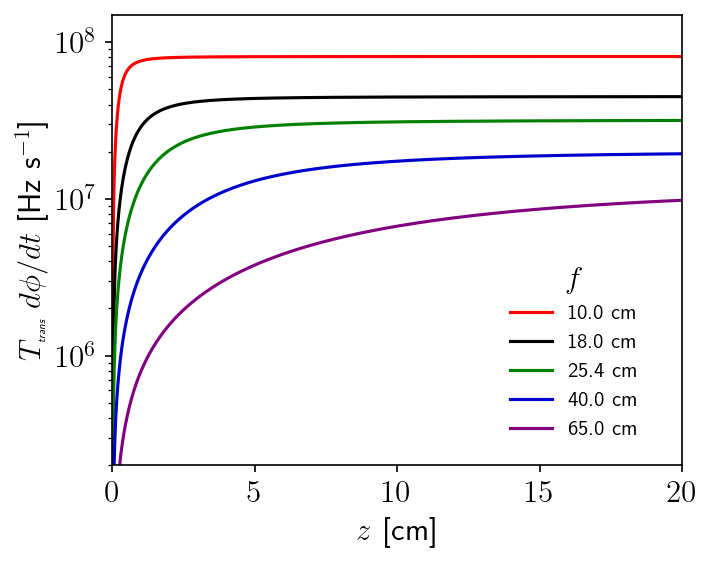

In [10]:
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = wl_nm, r, f
    label = '{f:2.1f} cm'.format(f=f)
    tr = transit_time(z,vx,params)
    ax.plot(z, tr*sweep_rate(z, vx, params), label=label, color=colors[f])
ax.set_xlim(0,20)
ax.set_ylim(2e5,1.5e8)
ax.set_yscale('log')
ax.set_xlabel('$z$ [cm]')
ax.legend(bbox_to_anchor=[.81,0.25], loc='center', frameon=False,title=r'$f$', fontsize=10)
ax.set_ylabel(r'$T_\textit{\tiny trans} \ {d\phi}/{dt}$ [Hz s$^{-1}$]')
fig.tight_layout()
fig.savefig('images/transition_rate.pdf', dpi=300)

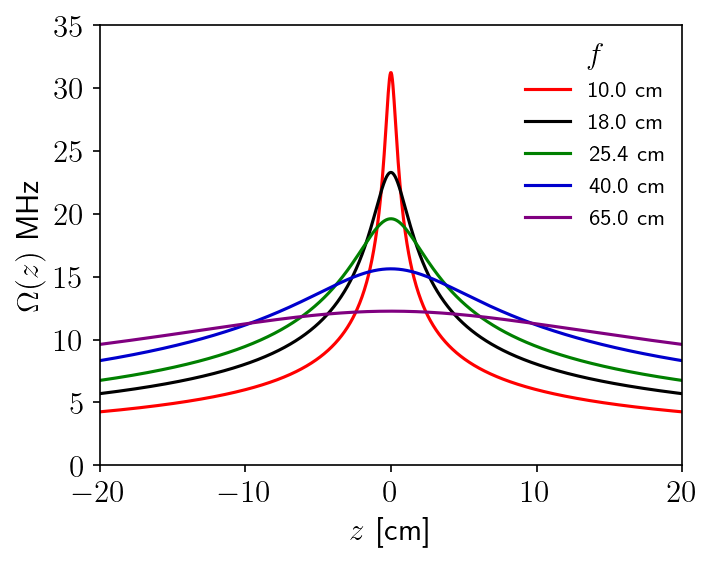

In [11]:
P = 0.080
Nz = 1000
v = 1500
delta_v = 10
divergence = 0.700
z = np.linspace(-20, 20, Nz)
fig, ax = plt.subplots(figsize=(5,4))
for f in focal_lengths:
    params = wl_nm, r,f
    label = '{f:2.1f} cm'.format(f=f)
    vel_xyz = sample_velocities(v, delta_v, divergence)
    E0 = Exy(0, z, P, vel_xyz, params)
    omega_r = E0*dipole/hbar
    ax.plot(z, omega_r/1e6, label=label, color=colors[f])
ax.set_xlim(-20,20)
ax.set_ylim(0,35.0)
ax.set_xlabel('$z$ [cm]')
ax.legend(bbox_to_anchor=[.85,0.75], loc='center', frameon=False,title=r'$f$', fontsize=11)
ax.set_ylabel(r'$\Omega(z)$ MHz')
fig.tight_layout()
fig.savefig('images/rabi_frequency.pdf', dpi=300)
fig.savefig('images/rabi_frequency.png', dpi=300)

1500 10 0.7


/tmp/ipykernel_266938/2671967878.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=14)
/tmp/ipykernel_266938/2671967878.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=14)


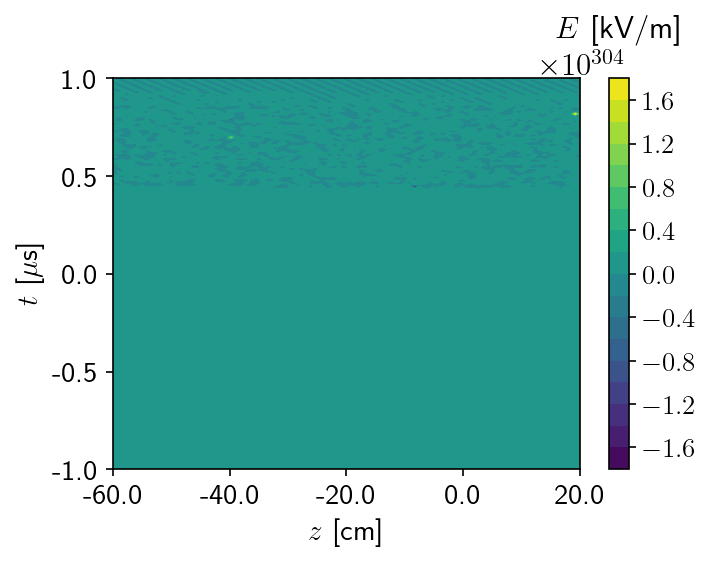

In [12]:
Nt = 200
Nz = 100
N_sample = 10000
v = 1500
print(v,delta_v, divergence)
t = np.linspace(-1e-6, 1e-6, Nt)
z = np.linspace(-50, 50, Nz)
Z, T = np.meshgrid(z, t)
E = np.empty((Nt, Nz), dtype=np.float64)
velocities = np.empty((N_sample, 3), dtype=np.float64)
for i in range(N_sample):
    vel_xyz = sample_velocities(v, delta_v, divergence)
    velocities[i,:] = vel_xyz
    E += Exy(T, Z, P, vel_xyz, params)/1e3
E = E/N_sample

fig, ax = plt.subplots(figsize=(5,4))
cs = ax.contourf(Z, T/1e-6, E, levels=21)
cbar = plt.colorbar(cs, spacing='proportional')
cbar.ax.set_title(r'$E$ [kV/m]', fontsize=15)
cbar.ax.tick_params(labelsize=13) 
fig.tight_layout()
ax.set_ylabel(r'$t$ [$\mu$s]',fontsize=14)
ax.set_xlabel(r'$z$ [cm]',fontsize=14)
ax.set_xticklabels(ax.get_xticks(), fontsize=14)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
# fig.suptitle(r'$E_{avg}$ felt by molecules')
fig.tight_layout()
fig.savefig('images/field_profile.pdf', dpi=300)
fig.savefig('images/field_profile.png', dpi=300)

In [13]:
# setting all constant parameters
input = {
        "wavelength_nm": wl_nm,
        "beam_radius": 0.20,
        "dipole_mom": dipole,
        "velocity_fwhm": 200.0,
        "divergence_fwhm": 0.7,
        "N_samples": 4000.0,
        "N_tstep": 500.0,
        "U0": 0.0,
        "V0": 0.0,
        "W0": -1.0,
        "rel_tol":1e-7,
        "abs_tol":1e-7,
        "max_tsteps":10000,
        "dt_max":1.0e-5,
}

In [14]:
def plot_property_data(data, x_key, param_key, title='', 
                    legend_title='', label_format='4.2f', legend_loc=(.80, .50),
                    colors={},
                    xlabel='', xlim=[], 
                    figsize=(5,4), save_fig=False, filename=''):
    fig, ax = plt.subplots(figsize=figsize)
    x = data[x_key]
    param_data = data[param_key]
    if colors=={}:
        tableau_palette = ['blue', 'orange','green','red','purple','brown','pink','gray','olive','cyan']
        colors = {ki: tableau_palette[i] for i, ki in enumerate(param_data.keys())}
    for ki in param_data:
        label = ('{k:'+label_format+'}').format(k=ki)
        ax.plot(x, param_data[ki], label=label, color=colors[ki])
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(r'$\textbf{N}_\textbf{ex}$',size=16)
    ax.set_xlim(np.min(x), np.max(x))
    ax.legend(bbox_to_anchor=legend_loc, loc='center', frameon=True, title=legend_title, fontsize=11, title_fontsize=11)
    if xlim != []:
        ax.set_xlim(xlim[0], xlim[1])
    ax.set_title(title)
    if save_fig:
        fig.tight_layout()
        fig.savefig(filename, dpi=350)
    return fig, ax

In [15]:
Nz = 40
input['velocity'] = 1500.00
input['power'] = 0.100
focal_length = [10, 18.0, 25.4, 40.0, 65.0] #cm
z = np.linspace(0.1, 40.0, Nz)
data1 = {'z': z}
focal_length_data = {}
for f in focal_length:
    input['focal_length'] = f
    n1 = np.empty(Nz, dtype=np.float64)
    for i in range(Nz):
        input['zi'] = z[i]
        n1[i] = calculate_ensemble_average(input)
    focal_length_data[f] = n1
data1['focal_length'] = focal_length_data 

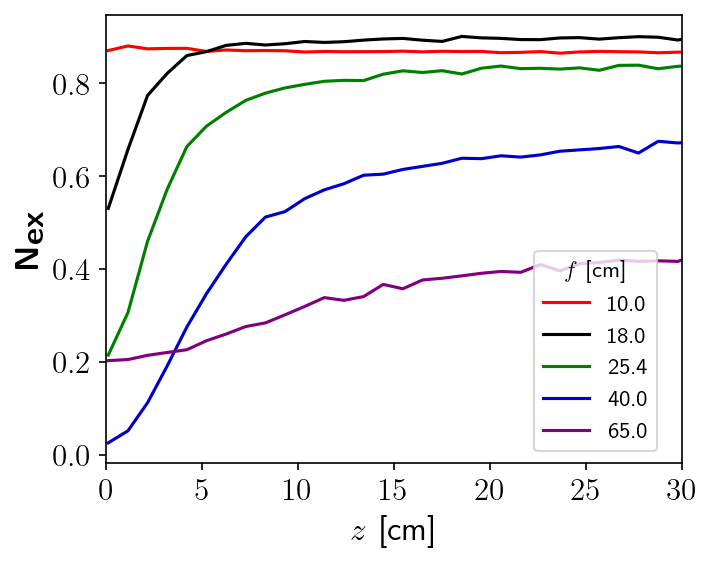

In [16]:
title = "RAP in CO (P=100mW ; $v_{x}$=1500 m/s)"
colors = {10.0:'red', 18.0:'black', 25.40:'green', 40.0:'mediumblue', 65.0:'purple'}
fig, ax = plot_property_data(data1, x_key='z', param_key='focal_length',
                             title="", legend_title=r'$f$ [cm]', label_format='4.1f', 
                             legend_loc=(.85, .250), 
                             xlabel=r'$z$ [cm]',xlim=[0, 30], colors=colors,
                             save_fig=True, filename='images/plot1.pdf')

In [17]:
fname = "../data/carbon_monoxide/p_8e-2_v_1500_f_fxn_z.npy"
np.save(fname, data1)

In [18]:
Np = 70
input['focal_length'] = 18.0
input['velocity'] = 1500.00
power = np.linspace(0.0, 0.300, Np)
data2 = {'power': power*1000}
power_data = {}
z = np.array([0.1, 1.25, 2.5, 5.0, 10.0])
for zi in z:
    input['zi'] = zi
    n1 = np.empty(Np, dtype=np.float64)
    for i in range(Np):
        input['power'] = power[i]
        n1[i] = calculate_ensemble_average(input)
    power_data[zi] = n1
data2['z'] = power_data

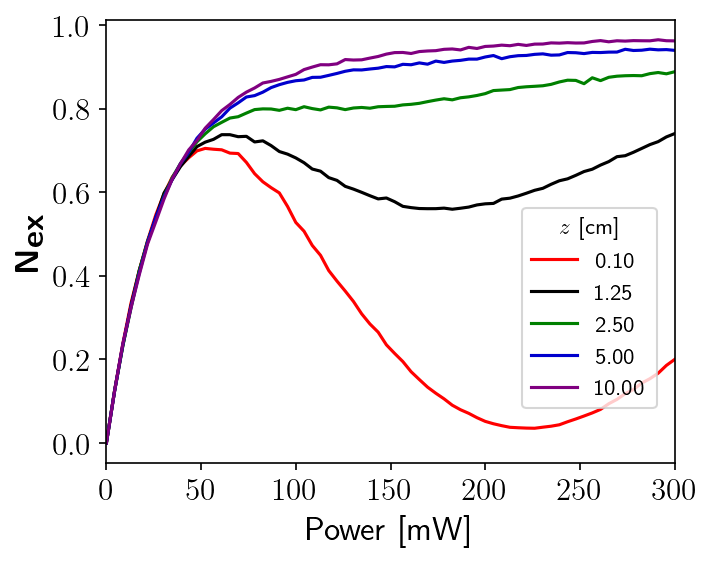

In [19]:
title = "RAP in CO (f=18.0cm ; $v_{x}$=1500 m/s)"
colors = {0.1:'red', 1.25:'black', 2.5:'green', 5.0:'mediumblue', 10.0:'purple'}
fig, ax = plot_property_data(data2, x_key='power', param_key='z',
                             title="", legend_title=r'$z$ [cm]',
                             xlabel='Power [mW]',xlim=[0, 300], colors=colors,
                             figsize=(5,4), legend_loc=[0.85,0.35],
                             save_fig=True, filename='images/plot2.pdf')
fig.savefig('images/plot2.pdf', dpi=350)
fig.savefig('images/plot2.png', dpi=350)

In [20]:
fname = "../data/carbon_monoxide/f_18_v_1500_z_fxn_p.npy"
np.save(fname, data2)

In [21]:
Np = 40
input['focal_length'] = 18.0
input['zi'] = 10.0
power = np.linspace(0.0, 0.150, Np)
data3 = {'power': power*1000}
power_data = {}
velocities = [1000, 1200, 1500, 1800, 2000, 2400, 2500]
for v in velocities:
    input['velocity'] = v
    n1 = np.empty(Np, dtype=np.float64)
    for i in range(Np):
        input['power'] = power[i]
        n1[i] = calculate_ensemble_average(input)
    power_data[v] = n1
data3['velocity'] = power_data

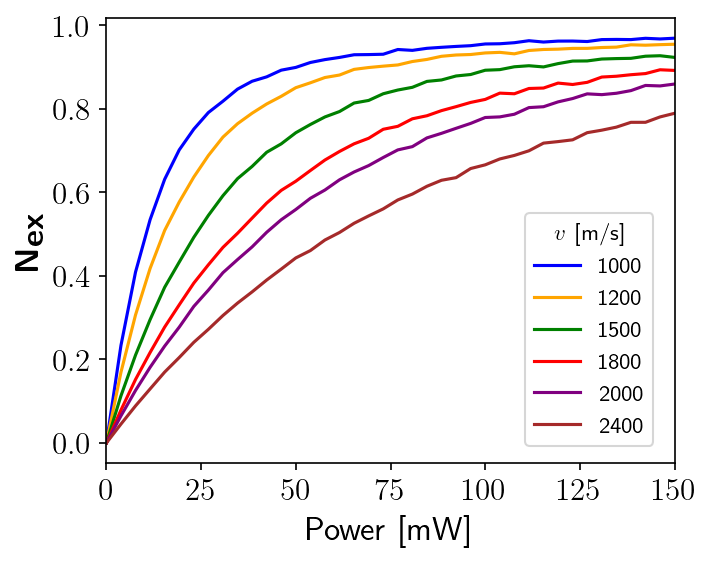

In [22]:
title = "RAP in CO (f=18.0cm z=10.0 cm)"
fig, ax = plot_property_data(data3, x_key='power', param_key='velocity',title='', 
                             legend_title=r'$v$ [m/s]', label_format='4.0f',
                             xlim=[0, 150], xlabel='Power [mW]', 
                             figsize=(5,4),
                             save_fig=True, filename='images/plot3.pdf')
ax.lines[-1].remove()
ax.legend(fontsize=11, bbox_to_anchor=(0.85,0.30), loc='center',title=r'$v$ [m/s]', title_fontsize=11)
fig.tight_layout()
fig.savefig('images/plot3.pdf', dpi=350)
fig.savefig('images/plot3.png', dpi=350)

In [23]:
fname = "../data/carbon_monoxide/f_18_z_10_v_fxn_p.npy"
np.save(fname, data3)

In [24]:
Np = 40
input['focal_length'] = 18.0
input['zi'] = 20.0
power = np.linspace(0.0, 0.150, Np)
data4 = {'power': power*1000}
power_data = {}
velocities = [1000, 1200, 1500, 1800, 2000, 2400, 2500]
for v in velocities:
    input['velocity'] = v
    n1 = np.empty(Np, dtype=np.float64)
    for i in range(Np):
        input['power'] = power[i]
        n1[i] = calculate_ensemble_average(input)
    power_data[v] = n1
data4['velocity'] = power_data

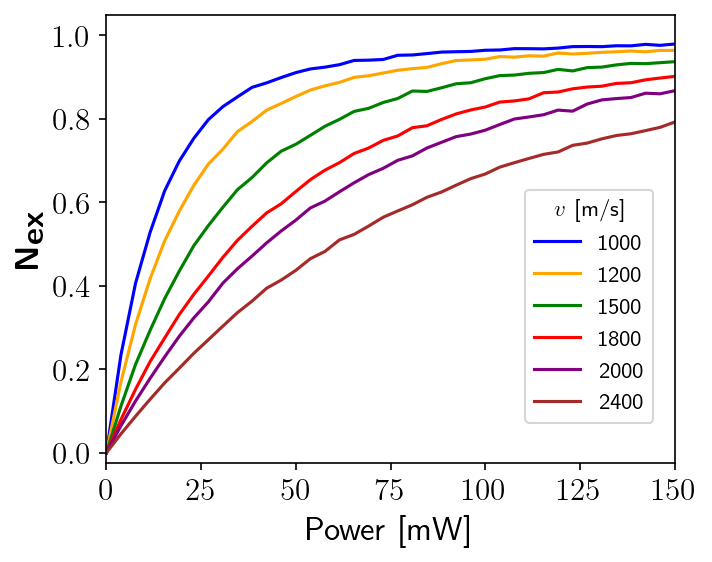

In [30]:
title = "RAP in CO (f=18.0cm z=20.0 cm)"
fig, ax = plot_property_data(data4, x_key='power', param_key='velocity',
                             title='', legend_title=r'$v$ [m/s]', label_format='4.0f',
                             xlabel='Power [mW]',xlim=[0, 150],
                             figsize=(5,4), legend_loc=[0.85,0.25],
                             save_fig=True, filename='images/plot4.pdf')
ax.set_ylim(-0.025,1.05)
ax.lines[-1].remove()
ax.legend(fontsize=11, bbox_to_anchor=(0.85,0.35), loc='center',title=r'$v$ [m/s]', title_fontsize=11)
fig.tight_layout()
fig.savefig('images/plot4.pdf', dpi=350)
fig.savefig('images/plot4.png', dpi=350)

In [26]:
fname = "../data/carbon_monoxide/f_18_z_05_v_fxn_p.npy"
np.save(fname, data4)

In [27]:
Nz = 40
input['velocity'] = 1500.00
input['power'] = 0.120
focal_lengths = [10, 18.0, 25.4, 40.0, 65.0] #cm
z = np.linspace(0.1, 30.0, Nz)
data5 = {'z': z}
focal_length_data = {}
for f in focal_length:
    input['focal_length'] = f
    n1 = np.empty(Nz, dtype=np.float64)
    for i in range(Nz):
        input['zi'] = z[i]
        n1[i] = calculate_ensemble_average(input)
    focal_length_data[f] = n1
data5['focal_length'] = focal_length_data 

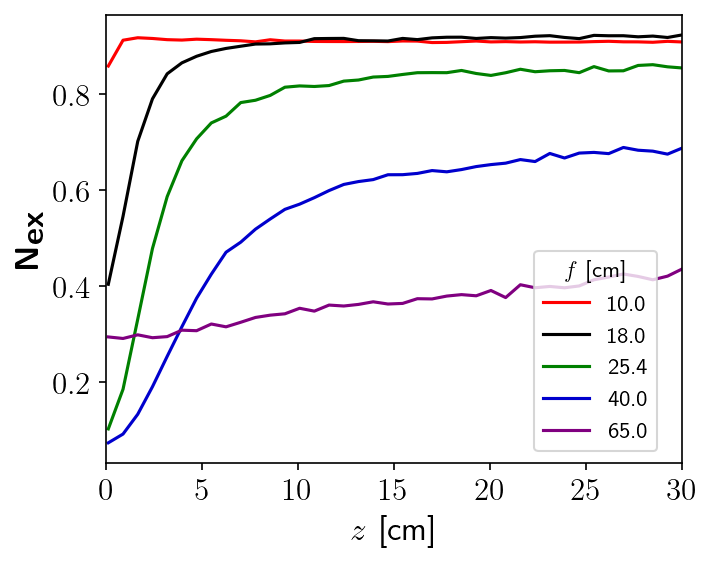

In [28]:
title = "RAP in CO (P=120mW ; $v_{x}$=1500 m/s)"
colors = {10.0:'red', 18.0:'black', 25.40:'green', 40.0:'mediumblue', 65.0:'purple'}
fig, ax = plot_property_data(data5, x_key='z', param_key='focal_length',
                             title="", 
                             legend_title=r'$f$ [cm]',label_format='4.1f', legend_loc=(.85, .25), 
                             xlabel=r'$z$ [cm]',xlim=[0, 30], colors=colors, 
                             save_fig=True, filename='images/plot5.pdf')

In [29]:
fname = "../data/carbon_monoxide/p_12e-1_v_1500_f_fxn_z.npy"
np.save(fname, data1)